# Análisis de salida del modelo de simulación de inventario

Este notebook es un tutorial sobre el análisis de salida para un modelo de simulación con terminación. Utiliza el modelo de simulación de inventario en inventory_simulation.py.

## Comparando simulaciones alternativas

En este apartado compararemos el rendimiento de dos sistemas para determinar cuál funciona mejor. En general, ejecutar una sola réplica de cada sistema no es una buena práctica, ya que la respuesta será aleatoria y corremos el riesgo de tomar una mala decisión. Tenemos entonces varios enfoques posibles para este problema. Primero vamos a ejecutar varias réplicas independientes de cada sistema y, a continuación, vamos a crear un intervalo de confianza para la diferencia por pares en los costos totales.

In [4]:
import numpy as np
from simulation.inventory_simulation import InventorySimulation

num_rep = 30

# create arrays to store data
res_config_1 = []
res_config_2 = []

for i in range(num_rep):
    # run first configuration
    simulation_1 = InventorySimulation(max_inventory=50, reorder_point=20)
    simulation_1.simulate(120)
    total_cost_1 = (sum(simulation_1.ordering_payments) + sum(simulation_1.storage_payments) + 5 * simulation_1.unsolded_products) / simulation_1.time
    res_config_1.append(total_cost_1)

    # run second configuration
    simulation_2 = InventorySimulation(max_inventory=80, reorder_point=20)
    simulation_2.simulate(120)
    total_cost_2 = (sum(simulation_2.ordering_payments) + sum(simulation_2.storage_payments) + 5 * simulation_2.unsolded_products) / simulation_2.time
    res_config_2.append(total_cost_2)

# compute the average for each sample
avg_config_1 = np.mean(res_config_1)
avg_config_2 = np.mean(res_config_2)

print('Average cost of (50, 20) per unit of time:', round(avg_config_1, 2))
print('Average cost of (80, 20) per unit of time:', round(avg_config_2, 2))

Average cost of (50, 20) per unit of time: 228.25
Average cost of (80, 20) per unit of time: 216.9


/tmp/ipykernel_31687/2081985464.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['(20, 50)', '(20, 80)'])


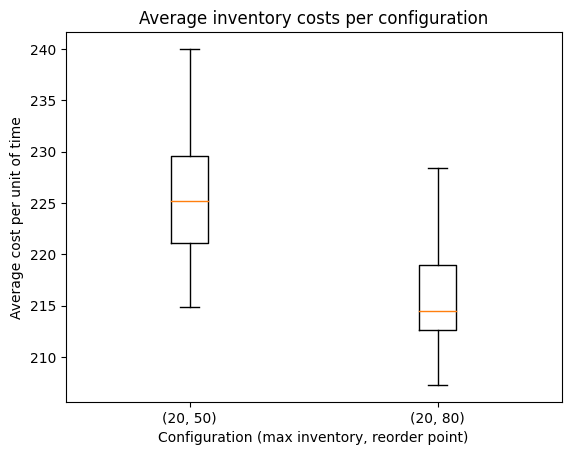

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

data = [res_config_1, res_config_2]

# create chart area
fig, ax = plt.subplots(dpi=100)
ax.set_xticklabels(['(20, 50)', '(20, 80)'])
ax.set_title('Average inventory costs per configuration')
ax.set_xlabel('Configuration (max inventory, reorder point)')
ax.set_ylabel('Average cost per unit of time')

# display boxplots
ax.boxplot(data)
plt.savefig('average_cost')
plt.show()

In [57]:
from scipy import stats

# substract pairwise costs
data = [m - n for m,n in zip(res_config_1, res_config_2)]

# compute sample mean and standard deviation
mean = np.mean(data)
std = np.std(data)

# compute t-statistics for a 90% confidence interval
alpha = 1-.9
tstat = stats.t.ppf(1-alpha/2, len(data) - 1)

# compute confidence interval
error_margin = tstat * std / np.sqrt(len(data))
lbound = mean - error_margin
ubound = mean + error_margin

print("90 percent confidence interval for cost difference: [%.1f, %.1f]" % (lbound, ubound))

90 percent confidence interval for cost difference: [7.7, 12.3]


In [5]:
import pandas as pd

# user inputs
num_rep = 10    # number of replications for each design point
reorder_points = np.arange(0,100,10)
max_inventory = np.arange(5,155,10)

results = []

for rp in reorder_points:
    for mi in max_inventory:
        r = {}
        for _ in range(num_rep):
            simulation = InventorySimulation(mi, rp)
            simulation.simulate(120)
            total_cost = (sum(simulation.ordering_payments) + sum(simulation.storage_payments) + 5 * simulation.unsolded_products) / simulation.time
            r = {'reorder_point': simulation.reorder_point,
            'max_inventory': simulation.max_inventory,
            'total_cost': round(total_cost, 1)}
        results.append(r)

results_df = pd.DataFrame(results)
results_df.to_csv('simulation_results.csv', index=False)

In [6]:
import pandas as pd
# load dataset as a data frame
results = pd.read_csv('simulation_results.csv')

# select relevant columns
data = results[['reorder_point', 'max_inventory', 'total_cost']]

# for each combination of order size and reorder point, compute average response
data = data.groupby(['reorder_point', 'max_inventory']).mean()

# reset data index and rename columns
data.reset_index(inplace = True)
data.columns = ['reorder_point', 'max_inventory', 'cost']

# pivot dataset
data = data.pivot('reorder_point', 'max_inventory')

/tmp/ipykernel_7807/2279652188.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.pivot('reorder_point', 'max_inventory')


In [7]:
# map values
X = data.columns.levels[1].values  # order sizes
Y = data.index.values # reorder points
Z = data.values # average total cost
Xi, Yi = np.meshgrid(X,Y)

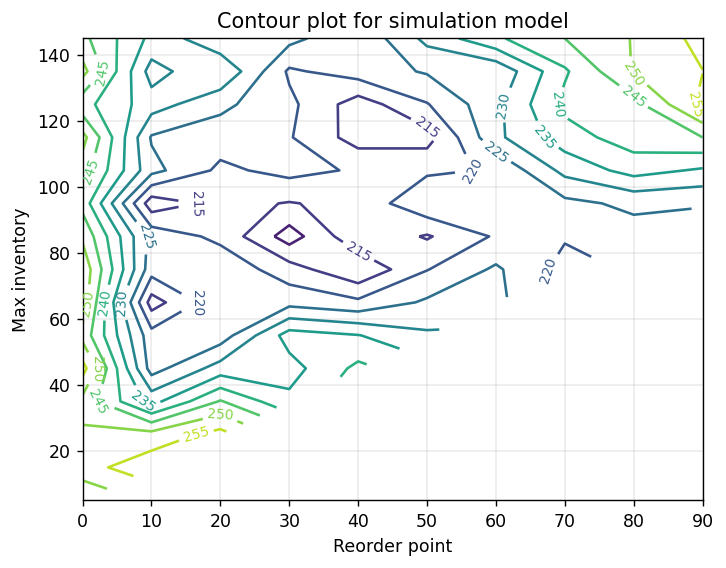

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# generate contour plot
plt.figure(dpi=125)
plt.title('Contour plot for simulation model')
plt.xlabel('Reorder point')
plt.ylabel('Max inventory')

contours = plt.contour(Yi, Xi, Z, 10)
plt.clabel(contours, inline=True, fmt='%1.0f', fontsize=8)
plt.grid(color='gray', linestyle='-', linewidth=.15)

plt.show()